In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, LeakyReLU, Layer, Conv2D, BatchNormalization, Flatten, Conv2DTranspose, Dropout
from tensorflow.keras.initializers import RandomNormal

In [ ]:
NOISE_DIM=100

In [ ]:
EPOCHS=50
BATCH_SIZE=128

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_x, train_y), (test_x, test_y) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
train_x = train_x/127.5 - 1
test_x = test_x/127.5 - 1

In [ ]:
train_x.min(),train_x.max()

(-1.0, 1.0)

In [ ]:
train_x = train_x.reshape(-1,28*28)

In [ ]:
dataset=tfds.load(name='fashion_mnist', split=tfds.Split.TRAIN)
dataset=dataset.map(lambda x: tf.cast(x['image'], tf.float32) / 127.5 - 1).batch(BATCH_SIZE)

In [ ]:
generator = tf.keras.models.Sequential([
    Dense(256, input_dim=NOISE_DIM), 
    LeakyReLU(0.2), 
    Dense(512), 
    LeakyReLU(0.2), 
    Dense(1024), 
    LeakyReLU(0.2), 
    Dense(28*28, activation='tanh'),
])

In [ ]:
discriminator = tf.keras.models.Sequential([
    Dense(1024, input_shape=(784,), kernel_initializer=RandomNormal(stddev=0.02)),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(512),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(256),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(1, activation='sigmoid')
])

In [ ]:
optm_g = tf.keras.optimizers.Adam(0.0002,0.5)
optm_d = tf.keras.optimizers.Adam(0.0002, 0.5)

In [ ]:
discriminator.compile(loss='binary_crossentropy',optimizer=optm_d)

In [ ]:
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,))
x = generator(inputs=gan_input)
output = discriminator(x)

In [ ]:
gan=tf.keras.Model(gan_input,output)
gan.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 784)               1486352   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [ ]:
gan.compile(loss='binary_crossentropy',optimizer=optm_g)

In [ ]:
def get_batches(data, batch_size):
    batches = []
    for i in range(int(data.shape[0] // batch_size)):
        batch = data[i * batch_size: (i + 1) * batch_size]
        batches.append(batch)
    return np.asarray(batches)

In [ ]:
def visualize_training(epoch, d_losses, g_losses):
    # 오차에 대한 시각화
    plt.figure(figsize=(8, 4))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generatror Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    print('epoch: {}, Discriminator Loss: {}, Generator Loss: {}'.format(epoch, np.asarray(d_losses).mean(), np.asarray(g_losses).mean()))
    
    #샘플 데이터 생성 후 시각화
    noise = np.random.normal(0, 1, size=(24, NOISE_DIM))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(-1, 28, 28)
    
    plt.figure(figsize=(8, 4))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 6, i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

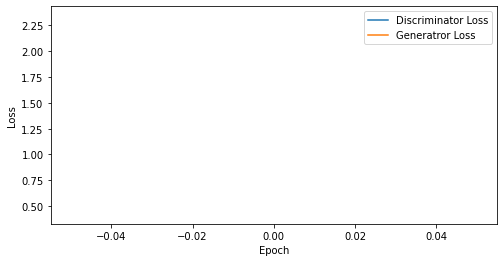

epoch: 1, Discriminator Loss: 0.4239956736564636, Generator Loss: 2.33952260017395


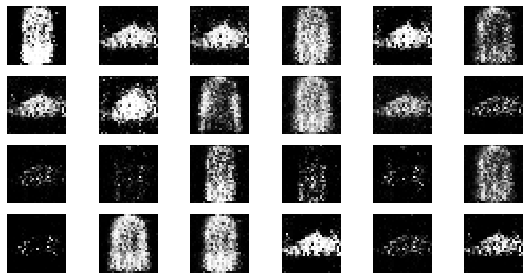

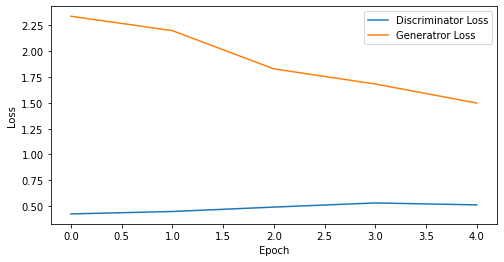

epoch: 5, Discriminator Loss: 0.4806554317474365, Generator Loss: 1.910202980041504


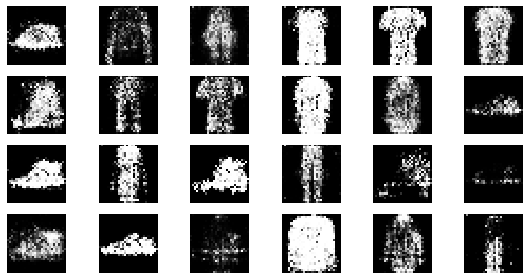

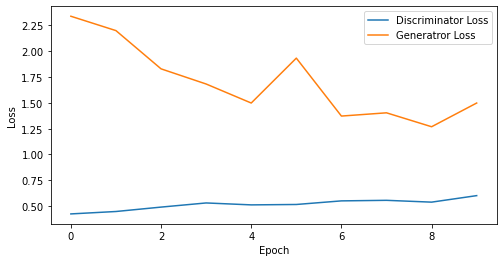

epoch: 10, Discriminator Loss: 0.5164125800132752, Generator Loss: 1.7027950048446656


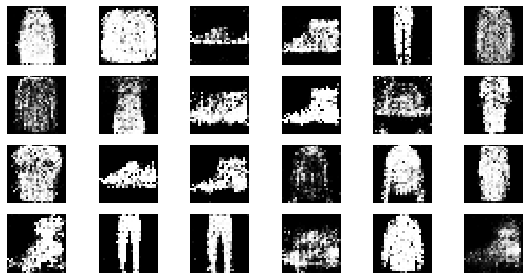

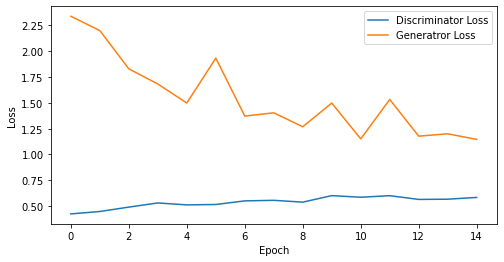

epoch: 15, Discriminator Loss: 0.5376866102218628, Generator Loss: 1.5490736881891887


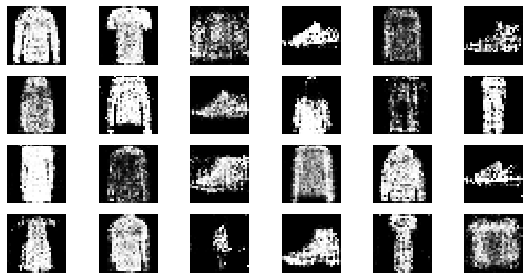

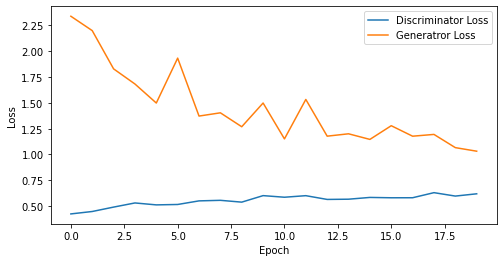

epoch: 20, Discriminator Loss: 0.5536101907491684, Generator Loss: 1.4492220520973205


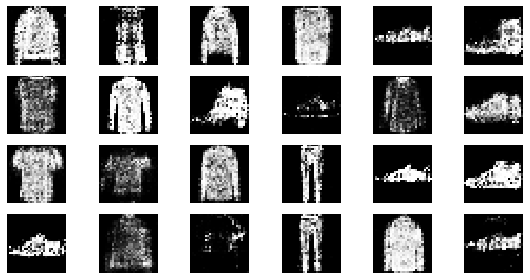

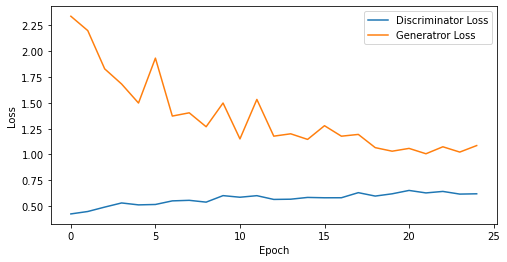

epoch: 25, Discriminator Loss: 0.5691262221336365, Generator Loss: 1.3693771743774414


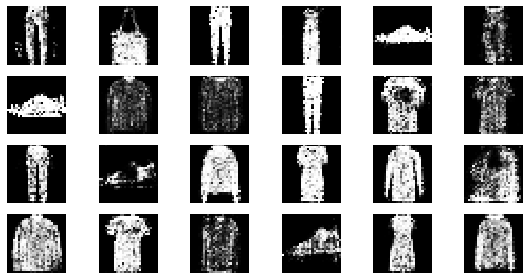

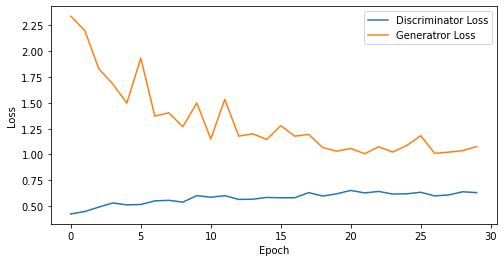

epoch: 30, Discriminator Loss: 0.5779000918070475, Generator Loss: 1.318775753180186


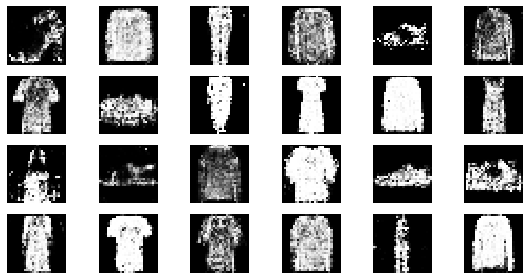

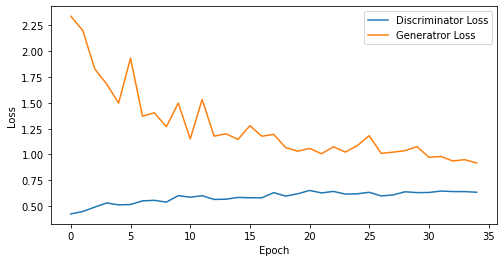

epoch: 35, Discriminator Loss: 0.5865363138062614, Generator Loss: 1.266317277295249


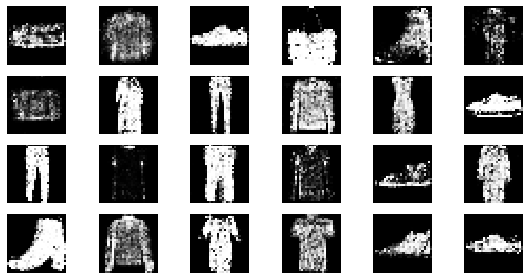

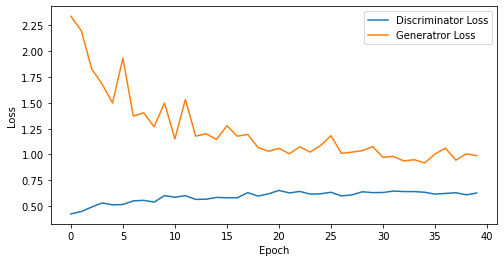

epoch: 40, Discriminator Loss: 0.590791167318821, Generator Loss: 1.2331786170601844


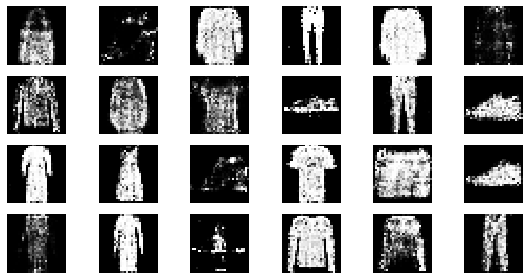

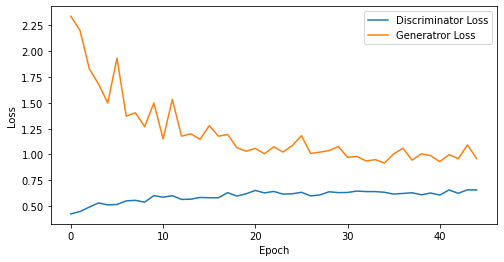

epoch: 45, Discriminator Loss: 0.5962585025363498, Generator Loss: 1.205952889389462


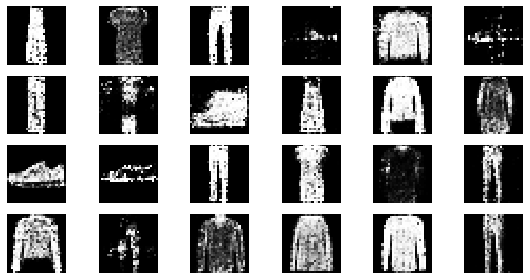

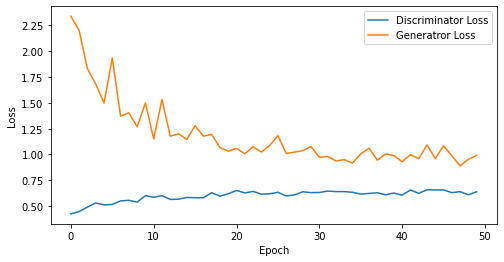

epoch: 50, Discriminator Loss: 0.6001309978961945, Generator Loss: 1.183486888408661


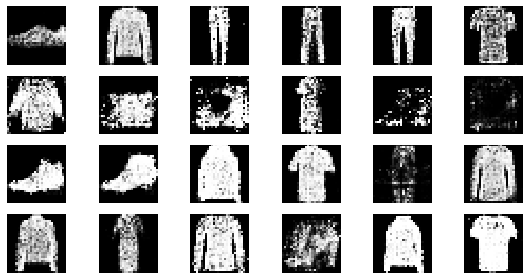

In [ ]:
d_losses = []
g_losses = []

for epoch in range(1, EPOCHS + 1):
    # 각 배치별 학습
    for real_images in get_batches(train_x, BATCH_SIZE):
        # 랜덤 노이즈 생성
        input_noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
        
        # 가짜 이미지 데이터 생성
        generated_images = generator.predict(input_noise)
        
        # Gan에 학습할 X 데이터 정의
        x_dis = np.concatenate([real_images, generated_images])
        
        # Gan에 학습할 Y 데이터 정의
        y_dis = np.zeros(2 * BATCH_SIZE)
        y_dis[:BATCH_SIZE] = 0.9
        
        # Discriminator 훈련
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(x_dis, y_dis)
        
        # Gan 훈련
        noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
        y_gan = np.ones(BATCH_SIZE)
        
        # Discriminator의 판별 학습을 방지합니다
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gan)
        
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    
    if epoch == 1 or epoch % 5 == 0:
        visualize_training(epoch, d_losses, g_losses)